# Hands-on 1: How to create a fMRI preprocessing workflow
*Written by Michael Notter & Luke Chang*

The purpose of this section is that you set-up a complete fMRI analysis workflow yourself. So that in the end, you are able to perform the analysis from A-Z, i.e. from preprocessing to group analysis. This section will cover the preprocessing part, and the section [Hands-on 2: Analysis](handson_analysis.ipynb) will handle the analysis part.

We will use this opportunity to show you some nice additional interfaces/nodes that might not be relevant to your usual analysis. But it's always nice to know that they exist. And hopefully, this will encourage you to investigate all other interfaces that Nipype can bring to the tip of your finger.

This notebook was taken from a more comprehensive [tutorial](https://github.com/miykael/nipype_tutorial) on nipype. I encourage you to check it out to learn about this tool in more depth.

## Preparation

Before we can start with anything we first need to download the data. For this hands-on, we will only use the right-handed subjects 2-4 and 7-9. This can be done very quickly with the following `datalad` command.

**Note:** This might take a while, as datalad needs to download ~200MB of data

**Note: You only need to download the data if you are running this locally on your laptop.  The data is already available on jupyterhub!**

In [ ]:
%%bash
datalad get -J 4 /data/ds000114/sub-0[234789]/ses-test/anat/sub-0[234789]_ses-test_T1w.nii.gz \
                /data/ds000114/sub-0[234789]/ses-test/func/*fingerfootlips*

# Preprocessing Workflow Structure

So let's get our hands dirty. First things first, it's always good to know which interfaces you want to use in your workflow and in which order you want to execute them. For the preprocessing workflow, I recommend that we use the following nodes:

     1. Gunzip (Nipype)
     2. Drop Dummy Scans (FSL)
     3. Slice Time Correction (SPM)
     4. Motion Correction (SPM)
     5. Artifact Detection
     6. Segmentation (SPM)
     7. Coregistration (FSL)
     8. Smoothing (FSL)
     9. Apply Binary Mask (FSL)
    10. Remove Linear Trends (Nipype)
    
**Note:** This workflow might be overkill concerning data manipulation, but it hopefully serves as a good Nipype exercise.

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [135]:
%matplotlib inline

from nilearn import plotting

# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/optnfs/el7/spm/spm12')

from os.path import join

your_netid = 'f00275v'
data_dir = '/dartfs/rc/lab/P/Psych60/data/ds000114'
output_dir = '/dartfs/rc/lab/P/Psych60/students_output/%s/7_nipype_preprocessing' % your_netid
# data_dir = '/dartfs-hpc/rc/home/v/f00275v/Psych60/data/brainomics_data'

**Note:** Ideally you would also put the imports of all the interfaces that you use here at the top. But as we will develop the workflow step by step, we can also import the relevant modules as we go.

## Create Nodes and Workflow connections

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Workflow

We recommend to create the workflow and establish all its connections at a later place in your script. This helps to have everything nicely together. But for this hands-on example, it makes sense to establish the connections between the nodes as we go.

And for this, we first need to create a workflow:

In [ ]:
# Create the workflow here
# Hint: use 'base_dir' to specify where to store the working directory

In [8]:
preproc = Workflow(name='work_preproc', base_dir=join(output_dir, 'output/'))

### Gunzip

I've already created the `Gunzip` node as a template for the other nodes. Also, we've specified an `in_file` here so that we can directly test the nodes without worrying about the Input/Output data stream to the workflow. This will be taken care of in a later section.

In [9]:
from nipype.algorithms.misc import Gunzip

In [10]:
# Specify example input file
func_file = join(data_dir, 'sub-07/ses-test/func/sub-07_ses-test_task-fingerfootlips_bold.nii.gz')

# Initiate Gunzip node
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### Drop Dummy Scans

The functional images of this dataset were recorded with 4 dummy scans at the beginning (see the [corresponding publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/)). But those dummy scans were not yet taken out from the functional images.

To better illustrate this, let's plot the time course of a random voxel of the just defined `func_file`:

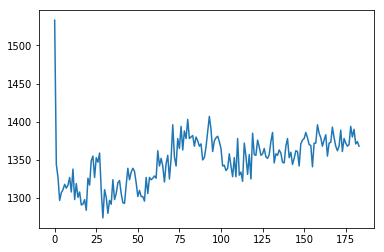

In [11]:
%matplotlib inline

import nibabel as nb
import matplotlib.pyplot as plt
plt.plot(nb.load(func_file).get_fdata()[32, 32, 15, :]);

In the figure above, we see that at the very beginning there are extreme values, which hint to the fact that steady state wasn't reached yet. Therefore, we want to exclude the dummy scans from the original data. This can be achieved with FSL's `ExtractROI`.

In [12]:
from nipype.interfaces.fsl import ExtractROI

In [13]:
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

This `ExtractROI` node can now be connected to the `gunzip_func` node from above. To do this, we use the following command:

In [15]:
preproc.connect([(gunzip_func, extract, [('out_file', 'in_file')])])

Exception: Trying to connect work_preproc.gunzip_func:out_file to work_preproc.extract:in_file but input 'in_file' of node 'work_preproc.extract' is already
connected.


### Slice Time Correction

Now to the next step. Let's us SPM's `SliceTiming` to correct for slice wise acquisition of the volumes. As a reminder, the tutorial dataset was recorded...
- with a time repetition (TR) of 2.5 seconds
- with 30 slices per volume
- in an interleaved fashion, i.e. slice order is [1, 3, 5, 7, ..., 2, 4, 6, ..., 30]
- with a time acquisition (TA) of 2.4167 seconds, i.e. `TR-(TR/num_slices)`

In [16]:
from nipype.interfaces.spm import SliceTiming

In [17]:
slice_order = list(range(1, 31, 2)) + list(range(2, 31, 2))
print(slice_order)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


In [18]:
# Initiate SliceTiming node here

In [19]:
slicetime = Node(SliceTiming(num_slices=30,
                             ref_slice=15,
                             slice_order=slice_order,
                             time_repetition=2.5,
                             time_acquisition=2.5-(2.5/30)),
                 name='slicetime')

Now the next step is to connect the `SliceTiming` node to the rest of the workflow, i.e. the `ExtractROI` node.

In [20]:
# Connect SliceTiming node to the other nodes here

In [21]:
preproc.connect([(extract, slicetime, [('roi_file', 'in_files')])])

### Motion Correction

To correct for motion in the scanner, we will be using FSL's `MCFLIRT`.

In [22]:
from nipype.interfaces.fsl import MCFLIRT

In [23]:
# Initate MCFLIRT node here

In [24]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

Connect the `MCFLIRT` node to the rest of the workflow.

In [25]:
# Connect MCFLIRT node to the other nodes here

In [26]:
preproc.connect([(slicetime, mcflirt, [('timecorrected_files', 'in_file')])])

### Artifact Detection

We will use the really cool and useful `ArtifactDetection` tool from Nipype to detect motion and intensity outliers in the functional images. The interface is initiated as follows:

In [27]:
from nipype.algorithms.rapidart import ArtifactDetect

In [28]:
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

The parameters above mean the following:
- `norm_threshold` - Threshold to use to detect motion-related outliers when composite motion is being used
- `zintensity_threshold` - Intensity Z-threshold use to detection images that deviate from the mean
- `mask_type` - Type of mask that should be used to mask the functional data. *spm_global* uses an spm_global like calculation to determine the brain mask
- `parameter_source` - Source of movement parameters
- `use_differences` - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers

And this is how you connect this node to the rest of the workflow:

In [29]:
preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

### Segmentation of anatomical image

Now let's work on the anatomical image. In particular, let's use SPM's `NewSegment` to create probability maps for the gray matter, white matter tissue and CSF.

In [30]:
from nipype.interfaces.spm import NewSegment

In [31]:
# Use the following tissue specification to get a GM and WM probability map

tpm_img ='/optnfs/el7/spm/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

In [ ]:
# Initiate NewSegment node here

In [32]:
segment = Node(NewSegment(tissues=tissues), name='segment')

We will again be using a `Gunzip` node to unzip the anatomical image that we then want to use as input to the segmentation node. We again also need to specify the anatomical image that we want to use in this case. As before, this will later also be handled directly by the Input/Output stream.

In [33]:
# Specify example input file
anat_file = join(data_dir, 'sub-07/ses-test/anat/sub-07_ses-test_T1w.nii.gz')

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')

Now we can connect the `NewSegment` node to the rest of the workflow.

In [34]:
# Connect NewSegment node to the other nodes here

In [35]:
preproc.connect([(gunzip_anat, segment, [('out_file', 'channel_files')])])

### Compute Coregistration Matrix

As a next step, we will make sure that the functional images are coregistered to the anatomical image. For this, we will use FSL's `FLIRT` function. As we just created a white matter probability map, we can use this together with the Boundary-Based Registration (BBR) cost function to optimize the image coregistration. As some helpful notes...
- use a degree of freedom of 6
- specify the cost function as `bbr`
- use the `schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'`

In [36]:
from nipype.interfaces.fsl import FLIRT

In [37]:
# Initiate FLIRT node here

In [38]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/optnfs/el7/fsl/5.0.10/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

In [39]:
# Connect FLIRT node to the other nodes here

In [40]:
preproc.connect([(gunzip_anat, coreg, [('out_file', 'reference')]),
                 (mcflirt, coreg, [('mean_img', 'in_file')])
                 ])

As mentioned above, the `bbr` routine can use the subject-specific white matter probability map to guide the coregistration. But for this, we need to create a binary mask out of the WM probability map. This can easily be done by FSL's `Threshold` interface.

In [41]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")

Now, to select the WM probability map that the `NewSegment` node created, we need some helper function. Because the output field `partial_volume_files` form the segmentation node, will give us a list of files, i.e. `[[GM_prob], [WM_prob], [], [], [], []]`. Therefore, using the following function, we can select only the last element of this list.

In [42]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

# Connecting the segmentation node with the threshold node
preproc.connect([(segment, threshold_WM, [(('native_class_images', get_wm),
                                           'in_file')])])

Now we can just connect this `Threshold` node to the coregistration node from above.

In [43]:
# Connect Threshold node to coregistration node above here

In [44]:
preproc.connect([(threshold_WM, coreg, [('out_file', 'wm_seg')])])

### Apply Coregistration Matrix to functional image

Now that we know the coregistration matrix to correctly overlay the functional mean image on the subject-specific anatomy, we need to apply to coregistration to the whole time series. This can be achieved with FSL's `FLIRT` as follows:

In [45]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

**<span style="color:red">Important</span>**: As you can see above, we also specified a variable `desired_voxel_iso`. This is very important at this stage, otherwise `FLIRT` will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g. to 1-10GB per file). If you don't want to change the voxel resolution, use the additional parameter `no_resample=True`. Important, for this to work, you still need to define `apply_isoxfm`.

In [46]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(mcflirt, applywarp, [('out_file', 'in_file')]),
                 (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (gunzip_anat, applywarp, [('out_file', 'reference')])
                 ])

### Smoothing

Next step is image smoothing. The most simple way to do this is to use FSL's or SPM's `Smooth` function. But for learning purposes, let's use FSL's `SUSAN` workflow as it is implemented in Nipype. Note that this time, we are importing a workflow instead of an interface.

In [47]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth

If you type `create_susan_smooth?` you can see how to specify the input variables to the susan workflow. In particular, they are...
- `fwhm`: set this value to 4 (or whichever value you want)
- `mask_file`: will be created in a later step
- `in_file`: will be handled while connection to other nodes in the preproc workflow

In [48]:
# Initiate SUSAN workflow here

In [49]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4

In [50]:
# Connect Threshold node to coregistration node above here

In [51]:
preproc.connect([(applywarp, susan, [('out_file', 'inputnode.in_files')])])

### Create Binary Mask

There are many possible approaches on how you can mask your functional images. One of them is not at all, one is with a simple brain mask and one that only considers certain kind of brain tissue, e.g. gray matter.

For the current example, we want to create a dilated gray matter mask. For this purpose we need to:
1. Resample the gray matter probability map to the same resolution as the functional images
2. Threshold this resampled probability map at a specific value
3. Dilate this mask by some voxels to make the mask less conservative and more inclusive

The first step can be done in many ways (eg. using freesurfer's `mri_convert`, `nibabel`) but in our case, we will use FSL's `FLIRT`. The trick is to use the probability mask, as input file and a reference file.

In [52]:
from nipype.interfaces.fsl import FLIRT

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

The second and third step can luckily be done with just one node. We can take almost the same `Threshold` node as above. We just need to add another additional argument: `-dilF` - which applies a maximum filtering of all voxels.

In [53]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

Now we can connect the resample and the gray matter mask node to the segmentation node and each other.

In [54]:
preproc.connect([(segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                      ]),
                 (resample, mask_GM, [('out_file', 'in_file')])
                 ])

This should do the trick.

### Apply the binary mask

Now we can connect this dilated gray matter mask to the susan node, as well as actually applying this to the resulting smoothed images.

In [55]:
# Connect gray matter Mask node to the susan workflow here

In [56]:
preproc.connect([(mask_GM, susan, [('out_file', 'inputnode.mask_file')])])

To apply the mask to the smoothed functional images, we will use FSL's `ApplyMask` interface.

In [57]:
from nipype.interfaces.fsl import ApplyMask

**Important:** The susan workflow gives out a list of files, i.e. `[smoothed_func.nii]` instead of just the filename directly. If we would use a normal `Node` for `ApplyMask` this would lead to the following error:

    TraitError: The 'in_file' trait of an ApplyMaskInput instance must be an existing file name, but a value of ['/output/work_preproc/susan/smooth/mapflow/_smooth0/asub-07_ses-test_task-fingerfootlips_bold_mcf_flirt_smooth.nii.gz'] <class 'list'> was specified.


To prevent this we will be using a `MapNode` and specify the `in_file` as it's iterfield. Like this, the node is capable to handle a list of inputs as it will know that it has to apply itself iteratively to the list of inputs.

In [58]:
from nipype import MapNode

In [59]:
# Initiate ApplyMask node here

In [60]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

In [61]:
# Connect smoothed susan output file to ApplyMask node here

In [62]:
preproc.connect([(susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')])
                 ])

### Remove linear trends in functional images

Last but not least. Let's use Nipype's `TSNR` module to remove linear and quadratic trends in the functionally smoothed images. For this, you only have to specify the `regress_poly` parameter in the node initiation.

In [63]:
from nipype.algorithms.confounds import TSNR

In [64]:
# Initiate TSNR node here

In [65]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

In [66]:
# Connect the detrend node to the other nodes here

In [67]:
preproc.connect([(mask_func, detrend, [('out_file', 'in_file')])])

## Datainput with `SelectFiles` and `iterables` 

This is all nice and well. But so far we still had to specify the input values for `gunzip_anat` and `gunzip_func` ourselves. How can we scale this up to multiple subjects and/or multiple functional images and make the workflow take the input directly from the BIDS dataset?

For this, we need [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb)! It's rather simple, specify a template and fill-up the placeholder variables.

In [68]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/ses-{ses_id}/anat/'
                     'sub-{subject_id}_ses-test_T1w.nii.gz',
             'func': 'sub-{subject_id}/ses-{ses_id}/func/'
                     'sub-{subject_id}_ses-{ses_id}_task-{task_id}_bold.nii.gz'}

# Create SelectFiles node
sf = Node(SelectFiles(templates,
                      base_directory=data_dir,
                      sort_filelist=True),
          name='selectfiles')
sf.inputs.ses_id='test'
sf.inputs.task_id='fingerfootlips'

Now we can specify over which subjects the workflow should iterate. To test the workflow, let's still just look at subject 7.

In [69]:
subject_list = ['07']
sf.iterables = [('subject_id', subject_list)]

In [70]:
# Connect SelectFiles node to the other nodes here

In [71]:
preproc.connect([(sf, gunzip_anat, [('anat', 'in_file')]),
                 (sf, gunzip_func, [('func', 'in_file')])])

## Visualize the workflow

Now that we're done. Let's look at the workflow that we just created.

190416-10:45:49,342 nipype.workflow INFO:
	 Generated workflow graph: /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/graph.png (graph2use=colored, simple_form=True).


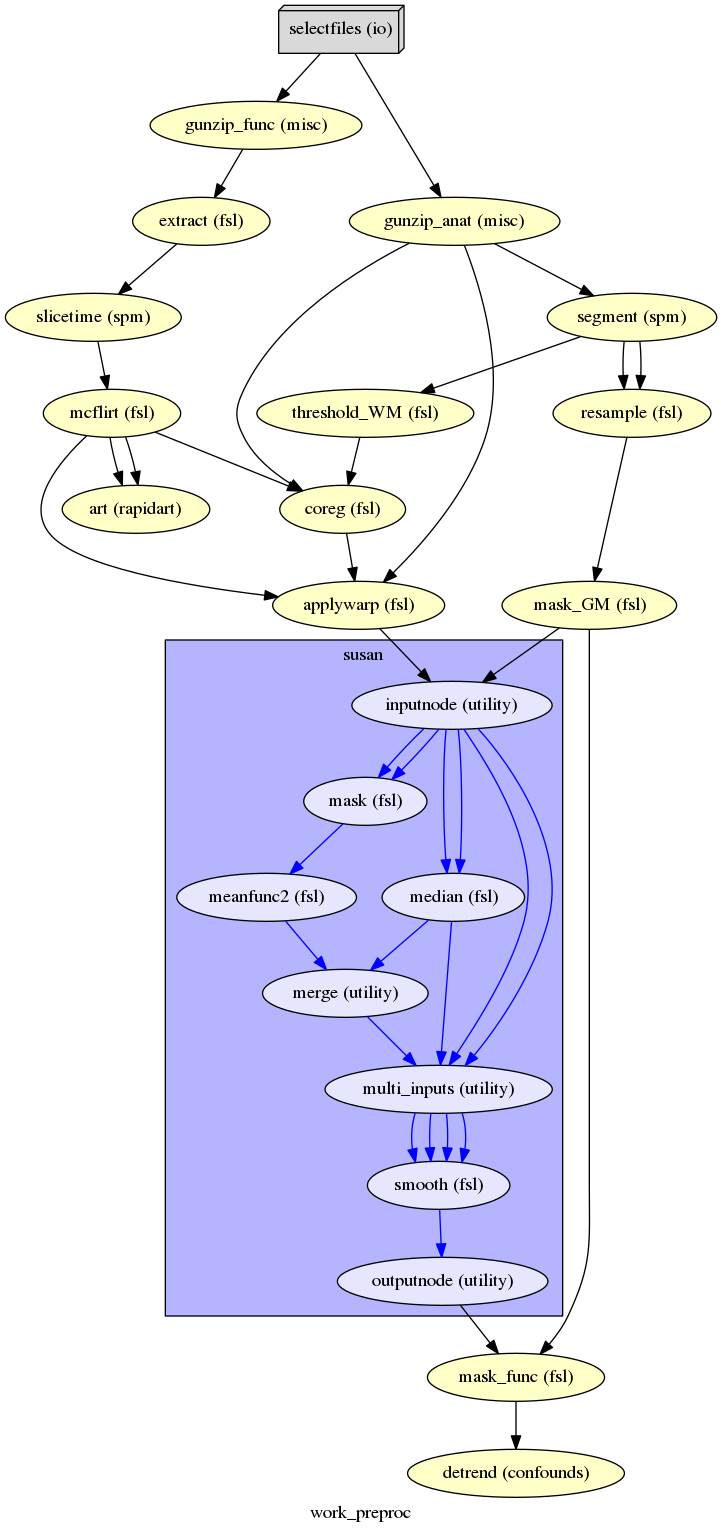

In [72]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=join(output_dir, 'output/work_preproc/graph.png'), width=750)

##  Run the Workflow

Now we are ready to run the workflow! Be careful about the `n_procs` parameter if you run a workflow in `'MultiProc'` mode. `n_procs` specifies the number of jobs/cores your computer will use to run the workflow. If this number is too high your computer will try to execute too many things at once and will most likely crash.

**Note**: If  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [73]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190416-10:45:58,544 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
190416-10:45:58,736 nipype.workflow INFO:
	 Running in parallel.
190416-10:45:58,746 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.


/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


190416-10:45:58,914 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/selectfiles".
190416-10:45:58,972 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190416-10:45:59,16 nipype.workflow INFO:
	 [Node] Finished "work_preproc.selectfiles".
190416-10:46:00,746 nipype.workflow INFO:
	 [Job 0] Completed (work_preproc.selectfiles).
190416-10:46:00,754 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.
190416-10:46:00,921 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_func" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/gunzip_func".
190416-10:46:00,925 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.gunzip_anat" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v

190416-10:51:57,286 nipype.workflow INFO:
	 [Node] Running "resample" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/segment/c1sub-07_ses-test_T1w.nii -ref /dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/segment/c1sub-07_ses-test_T1w.nii -out c1sub-07_ses-test_T1w_flirt.nii -omat c1sub-07_ses-test_T1w_flirt.mat -applyisoxfm 4.000000
190416-10:51:57,292 nipype.workflow INFO:
	 [Node] Running "threshold_WM" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/segment/c2sub-07_ses-test_T1w.nii -thr 0.5000000000 -bin /dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/threshold_WM/c2sub-

190416-10:55:39,327 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 55.98/56.38, Free processors: 2/4.
                     Currently running:
                       * work_preproc.susan.median
                       * work_preproc.susan.mask
190416-10:55:39,887 nipype.workflow INFO:
	 [Node] Finished "_median0".
190416-10:55:39,929 nipype.workflow INFO:
	 [Node] Finished "work_preproc.susan.median".
190416-10:55:41,327 nipype.workflow INFO:
	 [Job 15] Completed (work_preproc.susan.median).
190416-10:55:41,333 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 56.18/56.38, Free processors: 3/4.
                     Currently running:
                       * work_preproc.susan.mask
190416-10:55:46,899 nipype.workflow INFO:
	 [Node] Finished "_mask0".
190416-10:55:46,927 nipype.workflow INFO:
	 [Node] Finished "work_preproc.susan.mask".
190416-10:55:47,334 nipype.workflow INFO:
	 [Job 13] Completed (work_prep

190416-10:58:14,807 nipype.workflow INFO:
	 [Node] Finished "work_preproc.detrend".
190416-10:58:15,485 nipype.workflow INFO:
	 [Job 20] Completed (work_preproc.detrend).
190416-10:58:15,490 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.


## Inspect output

What did we actually do? Let's look at all the data that was created.

In [136]:
!tree -L 3 {join(output_dir, 'output/work_preproc/')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'


/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/
|-- graph.png
|-- _subject_id_02
|   |-- applywarp
|   |   |-- asub-02_ses-test_task-fingerfootlips_bold_roi_mcf_flirt.mat
|   |   `-- asub-02_ses-test_task-fingerfootlips_bold_roi_mcf_flirt.nii
|   |-- art
|   |   `-- plot.asub-02_ses-test_task-fingerfootlips_bold_roi_mcf.svg
|   |-- coreg
|   |   |-- asub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii.gz_mean_reg_flirt.mat
|   |   `-- asub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii.gz_mean_reg_flirt.nii
|   |-- datasink
|   |-- detrend
|   |   `-- detrend.nii.gz
|   |-- extract
|   |   `-- sub-02_ses-test_task-fingerfootlips_bold_roi.nii
|   |-- gunzip_anat
|   |   `-- sub-02_ses-test_T1w.nii
|   |-- gunzip_func
|   |   `-- sub-02_ses-test_task-fingerfootlips_bold.nii
|   |-- mask_func
|   |   `-- mapflow
|   |-- mask_GM
|   |   `-- c1sub-02_ses-test_T1w_flirt_thresh.nii
|   |-- mcflirt
|   |   |-- asub-02_ses-test_task-fingerfootlips

    |-- _subject_id_04
    |   |-- mask
    |   |-- meanfunc2
    |   |-- median
    |   |-- merge
    |   |-- multi_inputs
    |   `-- smooth
    |-- _subject_id_07
    |   |-- mask
    |   |-- meanfunc2
    |   |-- median
    |   |-- merge
    |   |-- multi_inputs
    |   `-- smooth
    |-- _subject_id_08
    |   |-- mask
    |   |-- meanfunc2
    |   |-- median
    |   |-- merge
    |   |-- multi_inputs
    |   `-- smooth
    `-- _subject_id_09
        |-- mask
        |-- meanfunc2
        |-- median
        |-- merge
        |-- multi_inputs
        `-- smooth

150 directories, 122 files


But what did we do specifically? Well, let's investigate.

### Motion Correction and Artifact Detection

How much did the subject move in the scanner and where there any outliers in the functional images?

In [74]:
%matplotlib inline

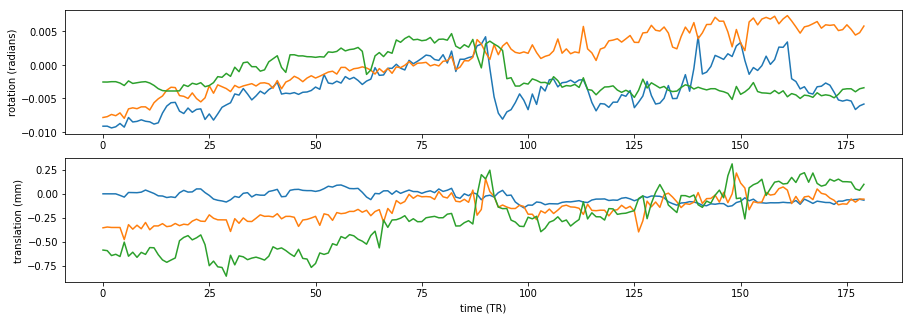

In [75]:
# Plot the motion paramters
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt(join(output_dir, 'output/work_preproc/_subject_id_07/mcflirt/'
                 'asub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii.gz.par'))
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

The motion parameters seems to look ok. What about the detection of artifacts?

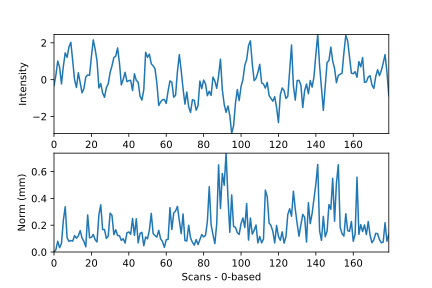

In [76]:
# Showing the artifact detection output
from IPython.display import SVG
SVG(filename=join(output_dir, 'output/work_preproc/_subject_id_07/art/',
    'plot.asub-07_ses-test_task-fingerfootlips_bold_roi_mcf.svg'))

Which volumes are problematic?

In [77]:
outliers = np.loadtxt(join(output_dir, 'output/work_preproc/_subject_id_07/art/',
                      'art.asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_outliers.txt'))
list(outliers.astype('int'))

/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: loadtxt: Empty input file: "/dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/art/art.asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_outliers.txt"
  


[]

### Masks and Probability maps

Let's see what all the masks and probability maps look like. For this, we will use `nilearn`'s `plot_anat` function.

In [82]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_stat_map

output = join(output_dir, 'output/work_preproc/_subject_id_07/')

First, let's look at the tissue probability maps.

In [137]:
anat = join(output, 'gunzip_anat/sub-07_ses-test_T1w.nii')

/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


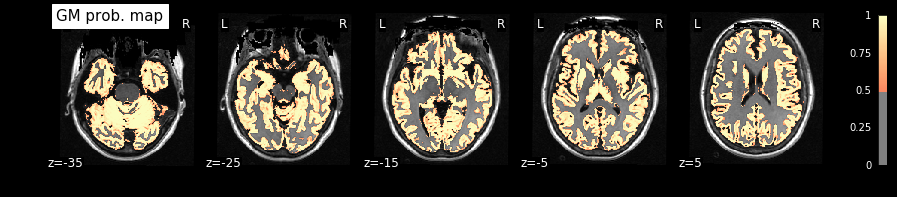

In [87]:
plot_stat_map(
    join(output, 'segment/c1sub-07_ses-test_T1w.nii'), title='GM prob. map',  cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


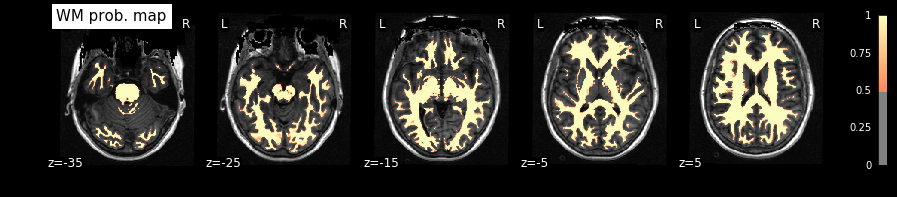

In [89]:
plot_stat_map(
    join(output, 'segment/c2sub-07_ses-test_T1w.nii'), title='WM prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


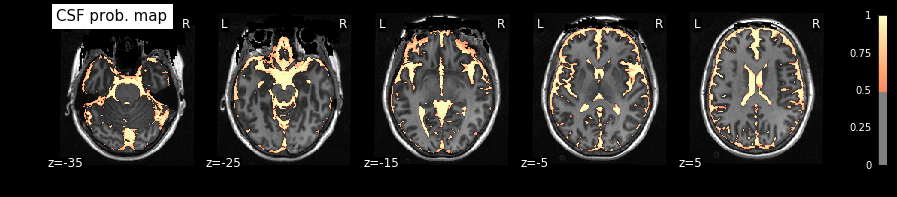

In [91]:
plot_stat_map(
    join(output, 'segment/c3sub-07_ses-test_T1w.nii'), title='CSF prob. map', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

And how does the gray matter mask look like that we used on the functional images?

/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


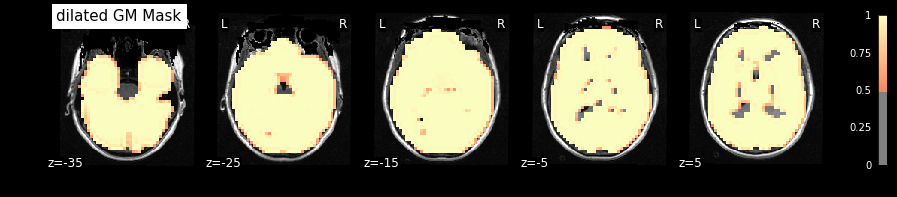

In [92]:
plot_stat_map(
    join(output, 'mask_GM/c1sub-07_ses-test_T1w_flirt_thresh.nii'), title='dilated GM Mask', cmap=plt.cm.magma,
    threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(-35, 15, 10), dim=-1);

### Functional Image transformations

Let's also investigate the transformation that we applied to the functional images.

In [93]:
%matplotlib inline

from nilearn import image as nli
from nilearn.plotting import plot_epi

output = join(output_dir, 'output/work_preproc/_subject_id_07/')

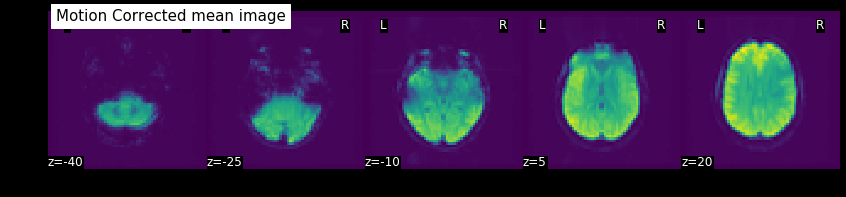

In [94]:
plot_epi(join(output, 'mcflirt/asub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii.gz_mean_reg.nii.gz'),
         title='Motion Corrected mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

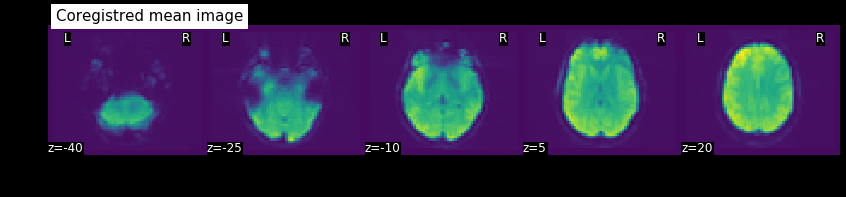

In [95]:
mean = nli.mean_img(join(output, 'applywarp/asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_flirt.nii'))
plot_epi(mean, title='Coregistred mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

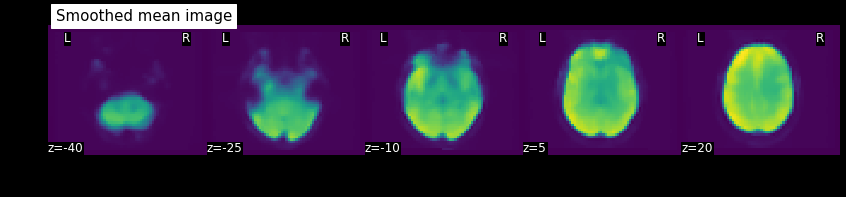

In [96]:
mean = nli.mean_img(join(output_dir, 'output/work_preproc/susan/_subject_id_07/smooth/mapflow/_smooth0/',
                    'asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_flirt_smooth.nii.gz'))
plot_epi(mean, title='Smoothed mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

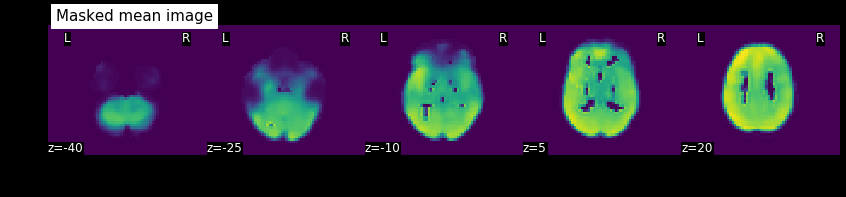

In [97]:
mean = nli.mean_img(join(output, 'mask_func/mapflow/_mask_func0/'
                    'asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_flirt_smooth_masked.nii'))
plot_epi(mean, title='Masked mean image', display_mode='z', cut_coords=range(-40, 21, 15),
         cmap=plt.cm.viridis);

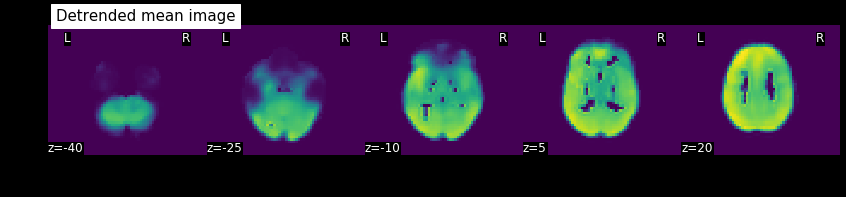

In [98]:
plot_epi(join(output, 'detrend/mean.nii.gz'), title='Detrended mean image', display_mode='z',
         cut_coords=range(-40, 21, 15), cmap=plt.cm.viridis);

That's all nice and beautiful, but what did smoothing and detrending actually do to the data?

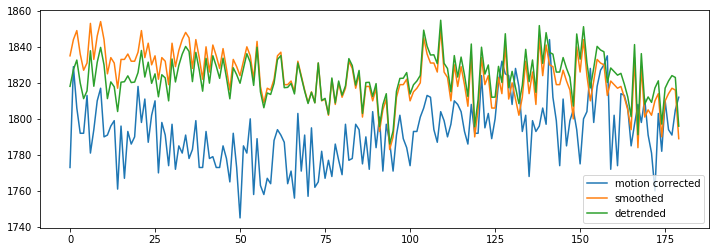

In [99]:
%matplotlib inline

import nibabel as nb

output = join(output_dir, 'output/work_preproc/_subject_id_07/')

# Load the relevant datasets
mc = nb.load(join(output, 'applywarp/asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_flirt.nii'))
smooth = nb.load(join(output_dir, 'output/work_preproc/susan/_subject_id_07/smooth/mapflow/',
                 '_smooth0/asub-07_ses-test_task-fingerfootlips_bold_roi_mcf_flirt_smooth.nii.gz'))
detrended_data = nb.load(output + 'detrend/detrend.nii.gz')

# Plot a representative voxel
x, y, z = 32, 34, 43
fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_data()[x, y, z, :])
plt.plot(smooth.get_data()[x, y, z, :])
plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(['motion corrected', 'smoothed', 'detrended']);

## Data output with `DataSink`

The results look fine, but we don't need all those temporary files. So let's use Datasink to keep only those files that we actually need for the 1st and 2nd level analysis.

In [100]:
from nipype.interfaces.io import DataSink

# Initiate the datasink node
output_folder = 'datasink_handson'
datasink = Node(DataSink(base_directory=join(output_dir, 'output/'),
                         container=output_folder),
                name="datasink")

Now the next step is to specify all the output that we want to keep in our output folder `output`. Make sure to keep:
- from the artifact detection node the outlier file as well as the outlier plot
- from the motion correction node the motion parameters
- from the last node, the detrended functional image

In [ ]:
# Connect nodes to datasink here

In [101]:
preproc.connect([(art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (detrend, datasink, [('detrended_file', 'preproc.@func')]),
                 ])

## Run the workflow

After adding the datasink folder, let's run the preprocessing workflow again.

In [102]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190416-11:30:54,227 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
190416-11:30:54,427 nipype.workflow INFO:
	 Running in parallel.
190416-11:30:54,434 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.


/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


190416-11:30:54,647 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/selectfiles".
190416-11:30:54,760 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190416-11:30:54,807 nipype.workflow INFO:
	 [Node] Finished "work_preproc.selectfiles".
190416-11:30:56,437 nipype.workflow INFO:
	 [Job 0] Completed (work_preproc.selectfiles).
190416-11:30:56,445 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.
190416-11:30:56,627 nipype.workflow INFO:
	 [Job 1] Cached (work_preproc.gunzip_func).
190416-11:30:56,637 nipype.workflow INFO:
	 [Job 6] Cached (work_preproc.gunzip_anat).
190416-11:30:58,572 nipype.workflow INFO:
	 [Job 2] Cached (work_preproc.extract).
190416-11:30:58,586 nipype.workflow INFO:
	 [Job 7] Cached (work_preproc.segment).
190416-11:31:0

Let's look now at the output of this datasink folder.



In [139]:
!tree -L 3 {join(output_dir, 'output/datasink_handson/')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/
`-- preproc
    |-- plot.sub-02.svg
    |-- plot.sub-03.svg
    |-- plot.sub-04.svg
    |-- plot.sub-07.svg
    |-- plot.sub-09.svg
    |-- sub-02_detrend.nii.gz
    |-- sub-02.par
    |-- sub-03_detrend.nii.gz
    |-- sub-03.par
    |-- sub-04_detrend.nii.gz
    |-- sub-04.par
    |-- sub-07_detrend.nii.gz
    |-- sub-07.par
    |-- sub-09_detrend.nii.gz
    `-- sub-09.par

1 directory, 15 files


Much better! But we're still not there yet. There are many unnecessary file specifiers that we can get rid off. To do so, we can use `DataSink`'s `substitutions` parameter. For this, we create a list of tuples: on the left, we specify the string that we want to replace and on the right, with what we want to replace it with.

In [103]:
## Use the following substitutions for the DataSink output
substitutions = [('asub', 'sub'),
                 ('_ses-test_task-fingerfootlips_bold_roi_mcf', ''),
                 ('.nii.gz.par', '.par'),
                 ]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

Before we run the preprocessing workflow again, let's first delete the current output folder:

In [114]:
# Delets the current output folder
!rm -rf {join(output_dir, 'output/datasink_handson')}


In [115]:
# Runs the preprocessing workflow again, this time with substitutions
preproc.run('MultiProc', plugin_args={'n_procs': 4})

190416-11:55:58,604 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
190416-11:55:58,809 nipype.workflow INFO:
	 Running in parallel.
190416-11:55:58,816 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.
190416-11:55:59,63 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/selectfiles".
190416-11:55:59,147 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190416-11:55:59,194 nipype.workflow INFO:
	 [Node] Finished "work_preproc.selectfiles".
190416-11:56:00,820 nipype.workflow INFO:
	 [Job 0] Completed (work_preproc.selectfiles).
190416-11:56:00,828 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 4/4.
190416-11:56:01,63 nip

In [141]:
!tree {join(output_dir, 'output/datasink_handson/')} -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'


/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/
`-- preproc
    |-- plot.sub-02.svg
    |-- plot.sub-03.svg
    |-- plot.sub-04.svg
    |-- plot.sub-07.svg
    |-- plot.sub-09.svg
    |-- sub-02_detrend.nii.gz
    |-- sub-02.par
    |-- sub-03_detrend.nii.gz
    |-- sub-03.par
    |-- sub-04_detrend.nii.gz
    |-- sub-04.par
    |-- sub-07_detrend.nii.gz
    |-- sub-07.par
    |-- sub-09_detrend.nii.gz
    `-- sub-09.par

1 directory, 15 files


# Run Preprocessing workflow on 6 right-handed subjects

Perfect! 

Now we might want to run this pipeline for many subjects.  In this example, we will run all right-handed subjects. For this, you just need to change the `subject_list` variable and run again the places where this variable is used (i.e. `sf.iterables` and in `DataSink` `substitutions`.

**NOTE**: For today due to the limited resources of our jupyter hub server, we will be just looking at the results that have already been run.  However, feel free to run this on your after class.

The full output can be viewed at the following location:

`/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing`


In [ ]:
# Update 'subject_list' and its dependencies here

In [119]:
subject_list = ['02', '03', '04', '07', '08', '09']

sf.iterables = [('subject_id', subject_list)]

In [120]:
# To get rid of the folder '_subject_id_02' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions

Now we can run the workflow again, this time for all right handed subjects in parallel.

In [142]:
# Runs the preprocessing workflow again, this time with substitutions
preproc.run('MultiProc', plugin_args={'n_procs': 8})

190416-12:41:17,521 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
190416-12:41:17,943 nipype.workflow INFO:
	 Running in parallel.
190416-12:41:17,958 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 8/8.


/optnfs/el7/jupyterhub/envs/Psych60-Chang/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


190416-12:41:18,272 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_09/selectfiles".
190416-12:41:18,279 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_08/selectfiles".
190416-12:41:18,283 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_07/selectfiles".
190416-12:41:18,288 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_nipype_preprocessing/output/work_preproc/_subject_id_04/selectfiles".
190416-12:41:18,292 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/dartfs/rc/lab/P/Psych60/students_output/f00275v/7_

190416-12:41:31,969 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 11 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 8/8.
190416-12:41:32,112 nipype.workflow INFO:
	 [Job 13] Cached (work_preproc.susan.mask).
190416-12:41:32,128 nipype.workflow INFO:
	 [Job 15] Cached (work_preproc.susan.median).
190416-12:41:32,144 nipype.workflow INFO:
	 [Job 35] Cached (work_preproc.susan.mask).
190416-12:41:32,158 nipype.workflow INFO:
	 [Job 37] Cached (work_preproc.susan.median).
190416-12:41:32,171 nipype.workflow INFO:
	 [Job 57] Cached (work_preproc.susan.mask).
190416-12:41:32,183 nipype.workflow INFO:
	 [Job 59] Cached (work_preproc.susan.median).
190416-12:41:32,198 nipype.workflow INFO:
	 [Job 77] Cached (work_preproc.coreg).
190416-12:41:32,207 nipype.workflow INFO:
	 [Job 90] Cached (work_preproc.extract).
190416-12:41:33,971 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 8/8.
190416-12:41:34,1

190416-12:41:46,252 nipype.interface INFO:
	 sub: /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/_subject_id_08/plot.asub-08_ses-test_task-fingerfootlips_bold_roi_mcf.svg -> /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/plot.sub-08.svg
190416-12:41:46,251 nipype.interface INFO:
	 sub: /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/_subject_id_09/plot.asub-09_ses-test_task-fingerfootlips_bold_roi_mcf.svg -> /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/plot.sub-09.svg
190416-12:41:46,255 nipype.interface INFO:
	 sub: /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/_subject_id_09/detrend.nii.gz -> /dartfs-hpc/rc/home/v/f00275v/Psych60/students

190416-12:41:56,298 nipype.interface INFO:
	 sub: /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/_subject_id_03/detrend.nii.gz -> /dartfs-hpc/rc/home/v/f00275v/Psych60/students_output/f00275v/7_nipype_preprocessing/output/datasink_handson/preproc/sub-03_detrend.nii.gz
190416-12:41:56,338 nipype.workflow INFO:
	 [Node] Finished "work_preproc.datasink".
190416-12:41:57,991 nipype.workflow INFO:
	 [Job 109] Completed (work_preproc.datasink).
190416-12:41:57,997 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 56.38/56.38, Free processors: 8/8.
190416-12:41:58,153 nipype.workflow INFO:
	 [Job 128] Cached (work_preproc.susan.smooth).
190416-12:42:00,140 nipype.workflow INFO:
	 [Job 129] Cached (work_preproc.mask_func).
190416-12:42:02,143 nipype.workflow INFO:
	 [Job 130] Cached (work_preproc.detrend).
190416-12:42:04,164 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.datas